In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

# Profit function

In [3]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Epsilon greedy hjælpefunktion

In [5]:
@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(Qtable[:, state])
    return price_index

# Q-learning and simulation function

In [6]:
@jit(nopython=True)
def Qfunction(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    Qtable_i = np.zeros((len(price_grid), len(price_grid)))
    Qtable_j = np.zeros((len(price_grid), len(price_grid)))
    Qtable_temp = np.zeros((len(price_grid), len(price_grid)))

    price_list = np.zeros(int(period))

    profit_1 = np.zeros(int(period))
    profit_2 = np.zeros(int(period))

    avg_profit_per_period = np.zeros(period)

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    for t in range(1, period + 1):
        state = price_index_j # the most recent draw of player i's price
        
        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            player_index = 1
            opponent_index = 0
        else:
            # player 1 is the responder
            player_index = 0
            opponent_index = 1

        # current period 
        decision = price_grid[price_index_i]
        state_i_responds_to = price_grid[state]
        profit_i_current_period = profit(decision, state_i_responds_to)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        price_index_j_next_period = epsilon_greedy(Qtable_j, epsilons[t], uniforms[t, opponent_index], state=state_next_period, price_grid=price_grid)

        price_j_next_period = price_grid[price_index_j_next_period]
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j_next_period])
        continuation_value = max_Q 

        new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, state]

        # Update Q-table for player i
        Qtable_i[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate

        # Profit opponent 
        profit_opponent = profit(state_i_responds_to, decision)
        
        # Average profit
        avg_profit_per_period[t-1] = (profit_i_current_period + profit_opponent) / 2

        # Price
        price_list[t-1] = price_grid[price_index_i]

         # Update for the next iteration: Use the simulated next period's action as the actual action for the opponent
        if t % 2 == 0:
            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_i_current_period
        else:
            profit_1[t-1] = profit_i_current_period
            profit_2[t-1] = profit_opponent

        # Switch player for next period
        Qtable_temp = Qtable_j
        Qtable_j = Qtable_i
        Qtable_i = Qtable_temp
        price_index_j = price_index_i
        price_index_i = price_index_j_next_period

    return avg_profit_per_period, profit_1, profit_2, price_list


@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    price_list_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array, price_list_array = Qfunction(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        price_list_sim[i] = price_list_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim, price_list_sim

# Time calculation for 1000 simulations

In [7]:
start_time  = time.time()

total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2, price_list = Simulations(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 46.01011824607849 seconds


In [8]:
print(price_list.shape)

(1000, 500000)


In [12]:
print(price_list[4,-40:])

[0.33333333 0.16666667 0.66666667 0.5        0.33333333 0.16666667
 0.66666667 0.5        0.33333333 0.16666667 0.66666667 0.5
 0.33333333 0.16666667 0.66666667 0.5        0.33333333 0.16666667
 0.66666667 0.5        0.33333333 0.16666667 0.66666667 0.5
 0.33333333 0.16666667 0.66666667 0.5        0.33333333 0.16666667
 0.66666667 0.5        0.33333333 0.16666667 0.66666667 0.5
 0.33333333 0.16666667 0.66666667 0.5       ]


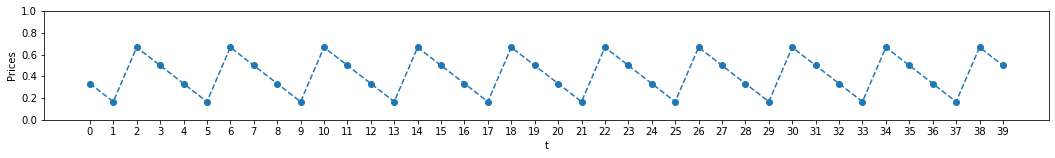

In [23]:
plt.figure(figsize=(18, 2))
plt.plot(price_list[4,-40:], '--o', label="Prices")
plt.xlabel('t')
plt.ylabel('Prices')
plt.ylim(0.00, 1.00)
plt.xticks(range(40))
plt.show()